## 📘 Notebook 1: Data Preparation & Analysis

**Funcionalidades:**
1. Carrega dataset da estrutura de pastas (data/odir5k/)
2. Data Loader otimizado para a nova estrutura
3. Data Augmentation para treino
4. Visualizações e estatísticas

In [1]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import seaborn as sns
from tqdm import tqdm

In [2]:
# Pega no caminho da pasta onde o notebook está (ex: .../notebooks)
CURRENT_DIR = os.getcwd()

# Define o PROJECT_ROOT como sendo a pasta "mãe" (odir-project)
PROJECT_ROOT = os.path.dirname(CURRENT_DIR) 

# Agora o DATASET_ROOT apontará corretamente para odir-project/data/odir5k
DATASET_ROOT = os.path.join(PROJECT_ROOT, "data", "odir5k")

print(f"Caminho do Notebook: {CURRENT_DIR}")
print(f"Raiz do Projeto: {PROJECT_ROOT}")
print(f"Caminho do Dataset: {DATASET_ROOT}")

# Verificar se agora o caminho está correto
if os.path.exists(DATASET_ROOT):
    print("✅ Sucesso: Pasta de dados encontrada!")
else:
    print("❌ Erro: A pasta ainda não foi encontrada. Verifica se o nome é 'odir5k' ou 'ODIR-5K'.")

Caminho do Notebook: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projetos/projects_faa/project2/odir-project/notebooks
Raiz do Projeto: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projetos/projects_faa/project2/odir-project
Caminho do Dataset: /home/carolina-silva/UA/MEI/1ºANO/1SEMESTRE/FAA/Projetos/projects_faa/project2/odir-project/data/odir5k
✅ Sucesso: Pasta de dados encontrada!


In [3]:
class ODIRDataset(Dataset):
    """Dataset ODIR-5K usando estrutura de pastas"""
    
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Carregar metadados
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        self.data = pd.read_csv(metadata_path)
        self.disease_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
        self.image_files = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        
        print(f"  📂 {split}: {len(self.data)} pacients, {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        patient_id = str(row['ID'])
        
        img_path = None
        for side in ['left', 'right']:
            img_name = f"{patient_id}_{side}.jpg"
            full_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(full_path):
                img_path = full_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Imagem não encontrada para ID {patient_id}")
        
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor([row[col] for col in self.disease_cols], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels, patient_id

In [4]:
class CropOnly(object):
        """Só cropping, SEM CLAHE"""
        
        def __call__(self, img):
            img = np.array(img)
            
            # Mesmo cropping que ApplyCLAHEandCrop_Adaptive mas SEM CLAHE
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray > 10
            if np.any(mask):
                coords = np.argwhere(mask)
                y0, x0 = coords.min(axis=0)
                y1, x1 = coords.max(axis=0) + 1
                img = img[y0:y1, x0:x1]
            
            return Image.fromarray(img)

In [5]:
class ApplyCLAHEandCrop_Adaptive(object):
    """
    CLAHE adaptativo: só aplica em imagens de baixo contraste
    """
    
    def __init__(self):
        self.contrast_threshold = 50   # ← OTIMIZADO!
        self.clip_limit = 3.0          # Suave
        self.tile_grid_size = (8, 8)
    
    def __call__(self, img):
        # To numpy (opencv)
        img = np.array(img)
        
        # ==================== CROPPING ====================
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray > 10
        
        if np.any(mask):
            coords = np.argwhere(mask)
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1
            img = img[y0:y1, x0:x1]
        
        # ==================== MEDIR CONTRASTE ====================
        gray_cropped = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        contrast = gray_cropped.std()  # Standard deviation = contraste
        
        # ==================== CLAHE ADAPTATIVO ====================
        # SÓ aplicar se contraste baixo!
        if contrast < self.contrast_threshold:
            # Converter para LAB
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            
            # Aplicar CLAHE no canal L
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            l = clahe.apply(l)
            
            # Merge e converter de volta
            img = cv2.merge([l, a, b])
            img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        
        # To PIL
        return Image.fromarray(img)

In [6]:
def get_train_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_train_transform_CLAHE():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_test_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_test_transform_CLAHE():
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [7]:
def visualize_step_by_step(dataset_basic, dataset_clahe, num_samples=3):
    fig, axes = plt.subplots(3, num_samples, figsize=(12, 10))
    fig.suptitle('Image Processing Evolution (Original -> Augmentation -> CLAHE + Crop', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # 1. ORIGINAL IMAGE
        row = dataset_basic.data.iloc[i]
        patient_id = str(row['ID'])
        img_name = f"{patient_id}_left.jpg"
        img_path = os.path.join(dataset_basic.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(dataset_basic.img_dir, f"{patient_id}_right.jpg")
        
        raw_img = Image.open(img_path).convert('RGB')
        raw_img = raw_img.resize((224, 224))
        axes[0, i].imshow(raw_img)
        axes[0, i].set_title(f'1. Original (ID: {patient_id})')
        axes[0, i].axis('off')

        # 2. AUGMENTATION ONLY
        img_aug, _, _ = dataset_basic[i]
        img_aug = img_aug.permute(1, 2, 0).numpy()
        img_aug = img_aug * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        axes[1, i].imshow(np.clip(img_aug, 0, 1))
        axes[1, i].set_title('2. Only Augmentation')
        axes[1, i].axis('off')

        # 3. CLAHE + CROP
        img_final, _, _ = dataset_clahe[i]
        img_final = img_final.permute(1, 2, 0).numpy()
        img_final = img_final * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        axes[2, i].imshow(np.clip(img_final, 0, 1))
        axes[2, i].set_title('3. FINAL (B): CLAHE + Augment')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('results/evolution_examples.png', dpi=150)
    plt.show()

def plot_dataset_statistics(save_path='results/dataset_statistics.png'):
    train_data = pd.read_csv(os.path.join(DATASET_ROOT, 'train', 'train_metadata.csv'))
    disease_names = {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 
                     'A': 'AMD', 'H': 'Hypertension', 'M': 'Myopia', 'O': 'Other'}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Dataset Statistics - Training Set', fontsize=16, fontweight='bold')
    
    # 1. Distribuição de doenças
    disease_counts = train_data[list(disease_names.keys())].sum().sort_values(ascending=False)
    axes[0, 0].bar(range(len(disease_counts)), disease_counts.values, color='steelblue')
    axes[0, 0].set_xticks(range(len(disease_counts)))
    axes[0, 0].set_xticklabels([disease_names[k] for k in disease_counts.index], rotation=45, ha='right')
    axes[0, 0].set_title('Disease Distribution')
    
    # 2. Distribuição de idade
    axes[0, 1].hist(train_data['Patient Age'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Age Distribution')
    
    # 3. Distribuição por sexo
    sex_counts = train_data['Patient Sex'].value_counts()
    axes[1, 0].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink'], startangle=90)
    axes[1, 0].set_title('Sex Distribution')
    
    # 4. Doenças por paciente
    diseases_per_patient = train_data[list(disease_names.keys())].sum(axis=1)
    axes[1, 1].hist(diseases_per_patient, bins=range(0, 9), color='mediumseagreen', edgecolor='black', alpha=0.7, align='left')
    axes[1, 1].set_title('Diseases per Pacient')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show() # Garante que aparece no Notebook
    print(f"  Estatísticas guardadas em: {save_path}")

  📂 train: 4474 pacients, 5732 images
  📂 train: 4474 pacients, 5732 images
  📂 val: 959 pacients, 1728 images
  📂 test: 959 pacients, 1748 images


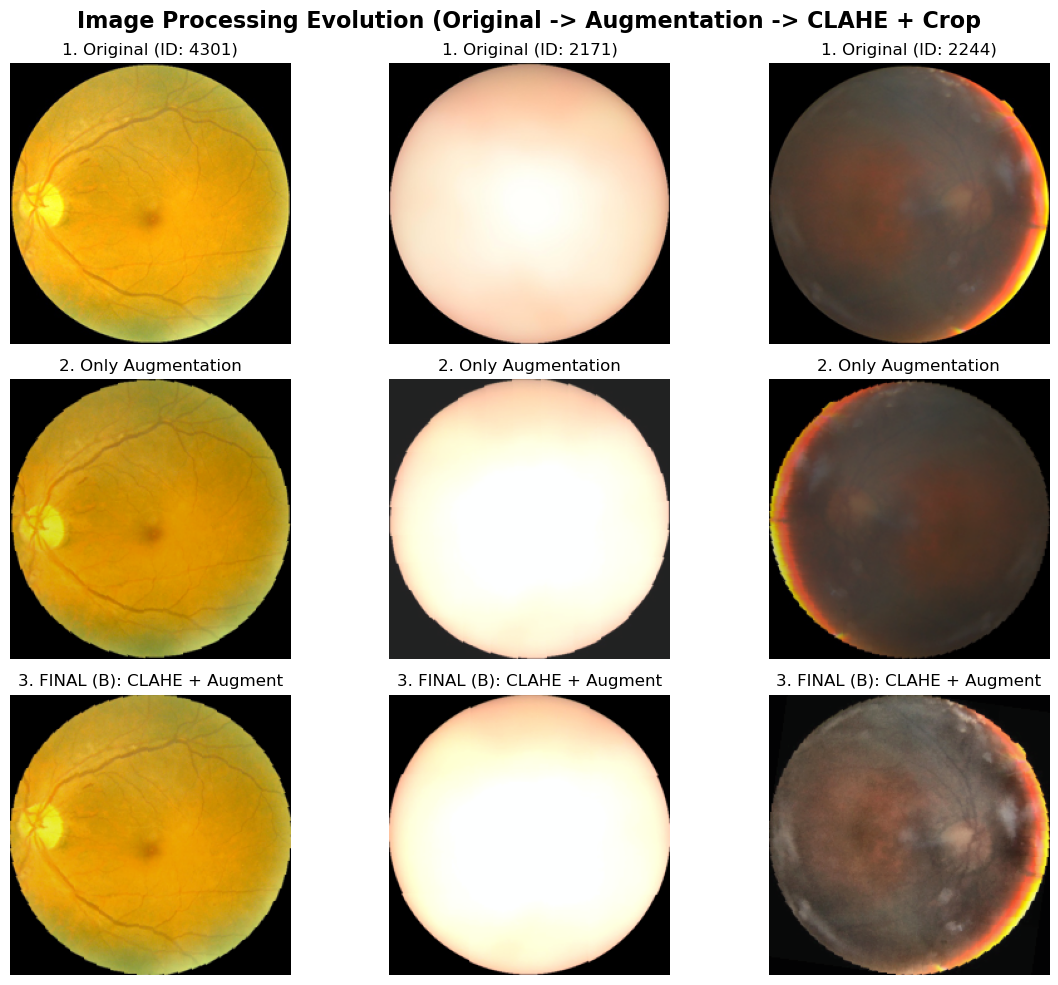

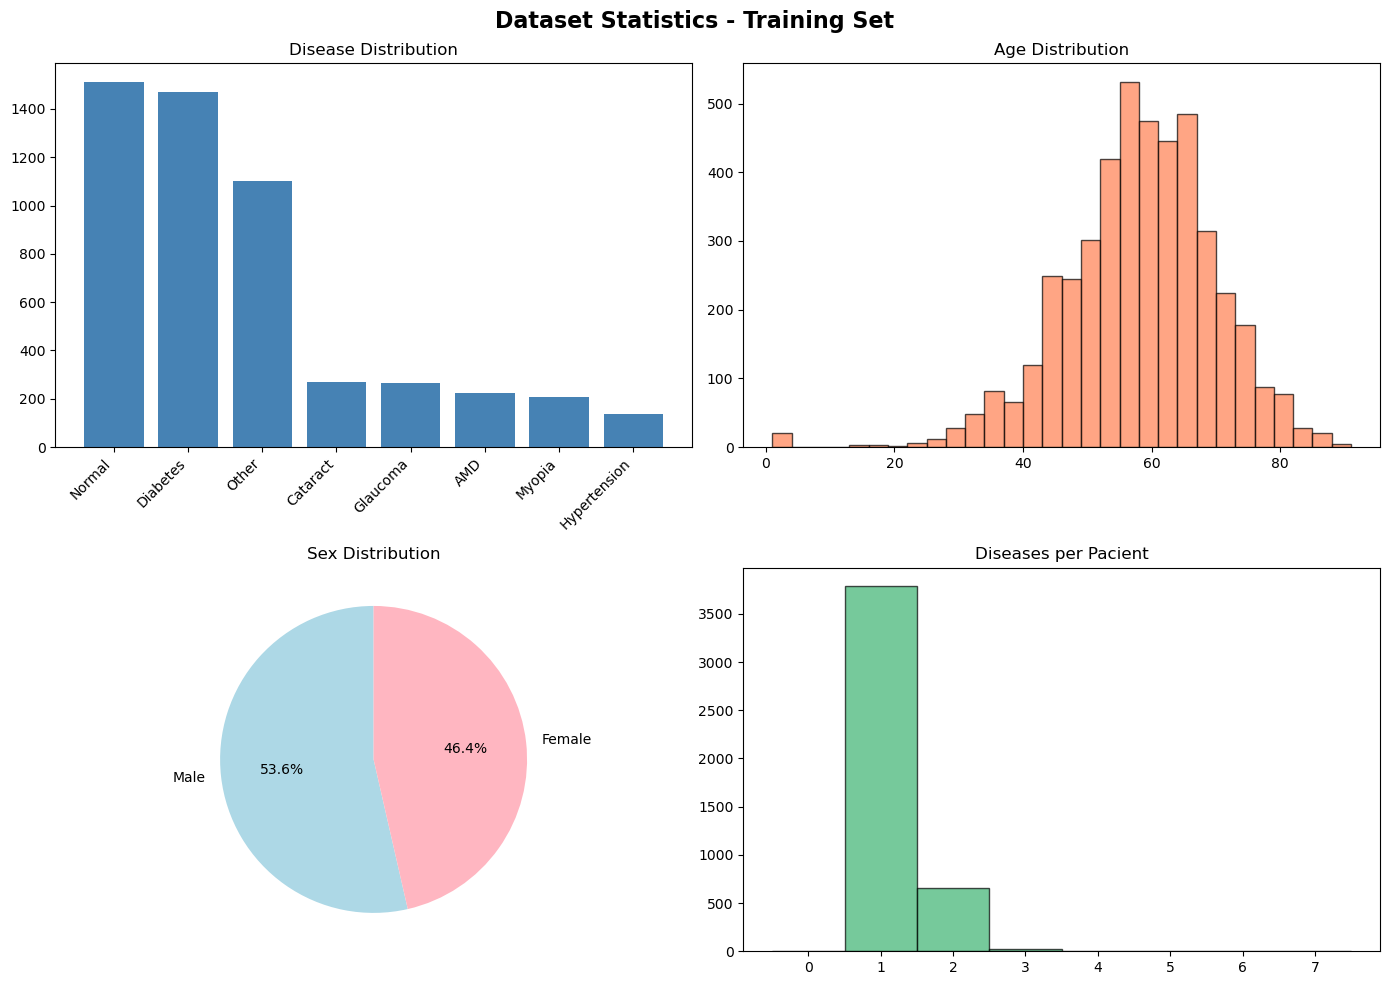

  Estatísticas guardadas em: results/dataset_statistics.png

 Resume: Train: 4474 | Val: 959 | Test: 959


In [8]:
# --- Verificação de Segurança e Execução ---
if not os.path.exists(DATASET_ROOT):
    print(f"❌ ERRO: Dataset não encontrado em {DATASET_ROOT}")
else:
    # 1. Criar Datasets Reais
    train_dataset_basic = ODIRDataset('train', transform=get_train_transform())
    train_dataset_clahe = ODIRDataset('train', transform=get_train_transform_CLAHE())
    
    val_dataset = ODIRDataset('val', transform=get_val_test_transform_CLAHE())
    test_dataset = ODIRDataset('test', transform=get_val_test_transform_CLAHE())

    visualize_step_by_step(train_dataset_basic, train_dataset_clahe)
    
    plot_dataset_statistics()

    print("\n Resume: Train:", len(train_dataset_clahe), "| Val:", len(val_dataset), "| Test:", len(test_dataset))

In [9]:
def print_dataset_summary():
    """Tabela formal para relatório"""
    train_data = pd.read_csv(os.path.join(DATASET_ROOT, 'train', 'train_metadata.csv'))
    val_data = pd.read_csv(os.path.join(DATASET_ROOT, 'val', 'val_metadata.csv'))
    test_data = pd.read_csv(os.path.join(DATASET_ROOT, 'test', 'test_metadata.csv'))
    
    summary = pd.DataFrame({
        'Split': ['Training', 'Validation', 'Test', 'Total'],
        'Patients': [
            len(train_data['ID'].unique()),
            len(val_data['ID'].unique()),
            len(test_data['ID'].unique()),
            len(train_data['ID'].unique()) + len(val_data['ID'].unique()) + len(test_data['ID'].unique())
        ],
        'Images': [len(train_data), len(val_data), len(test_data), 
                   len(train_data) + len(val_data) + len(test_data)],
        'Percentage': [
            f"{len(train_data)/(len(train_data)+len(val_data)+len(test_data))*100:.1f}%",
            f"{len(val_data)/(len(train_data)+len(val_data)+len(test_data))*100:.1f}%",
            f"{len(test_data)/(len(train_data)+len(val_data)+len(test_data))*100:.1f}%",
            "100%"
        ]
    })
    
    print("\n" + "="*60)
    print("DATASET SUMMARY - ODIR-5K")
    print("="*60)
    print(summary.to_string(index=False))
    
    # Salvar para LaTeX
    with open('results/dataset_summary.tex', 'w') as f:
        f.write(summary.to_latex(index=False))
    
    return summary

In [10]:
def plot_disease_cooccurrence(train_data, save_path='results/cooccurrence_heatmap.png'):
    """Heatmap de correlação entre doenças"""
    disease_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_full = {
        'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 
        'C': 'Cataract', 'A': 'AMD', 'H': 'Hypertension',
        'M': 'Myopia', 'O': 'Other'
    }
    
    # Criar matriz de co-occurrence
    disease_matrix = train_data[disease_names].values
    cooccurrence = np.dot(disease_matrix.T, disease_matrix)
    
    # Normalizar por diagonal (Jaccard similarity)
    diag = np.diag(cooccurrence)
    normalized = cooccurrence / (diag[:, None] + diag[None, :] - cooccurrence + 1e-8)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(normalized, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=[disease_full[d] for d in disease_names],
                yticklabels=[disease_full[d] for d in disease_names],
                cbar_kws={'label': 'Jaccard Similarity'})
    
    plt.title('Disease Co-occurrence Matrix (Training Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Encontrar pares mais comuns
    print("\n🔍 Most Common Disease Pairs:")
    pairs = []
    for i in range(len(disease_names)):
        for j in range(i+1, len(disease_names)):
            count = cooccurrence[i, j]
            if count > 0:
                pairs.append((disease_full[disease_names[i]], 
                             disease_full[disease_names[j]], 
                             int(count)))
    
    pairs.sort(key=lambda x: x[2], reverse=True)
    for d1, d2, count in pairs[:10]:
        print(f"  {d1} + {d2}: {count} cases")

In [11]:
def analyze_multilabel_distribution(train_data):
    """Análise de quantas doenças por paciente"""
    disease_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    # Contar doenças por imagem
    diseases_per_image = train_data[disease_names].sum(axis=1)
    
    print("\n Multi-label Statistics:")
    print(f"  Images with 0 diseases: {(diseases_per_image == 0).sum()} ({(diseases_per_image == 0).sum()/len(train_data)*100:.1f}%)")
    print(f"  Images with 1 disease: {(diseases_per_image == 1).sum()} ({(diseases_per_image == 1).sum()/len(train_data)*100:.1f}%)")
    print(f"  Images with 2+ diseases: {(diseases_per_image >= 2).sum()} ({(diseases_per_image >= 2).sum()/len(train_data)*100:.1f}%)")
    print(f"  Max diseases per image: {diseases_per_image.max()}")
    print(f"  Mean diseases per image: {diseases_per_image.mean():.2f}")
    
    # Estatísticas por doença
    print("\n📈 Per-Disease Statistics:")
    for disease in disease_names:
        count = train_data[disease].sum()
        pct = count / len(train_data) * 100
        full_name = {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 
                     'C': 'Cataract', 'A': 'AMD', 'H': 'Hypertension',
                     'M': 'Myopia', 'O': 'Other'}[disease]
        print(f"  {full_name:15s}: {count:4d} ({pct:5.1f}%)")

In [12]:
def analyze_image_quality(dataset, num_samples=500, save_path='results/quality_analysis.png'):
    """Análise de qualidade das imagens"""
    print(f"\n Analyzing image quality ({num_samples} samples)...")
    
    intensities = []
    contrasts = []
    black_border_percentages = []
    
    for i in tqdm(range(min(num_samples, len(dataset)))):
        img, _, _ = dataset[i]
        
        # Converter para numpy (se for tensor)
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        
        # Grayscale para análise
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        
        # Intensidade média
        intensities.append(gray.mean())
        
        # Contraste (std da intensidade)
        contrasts.append(gray.std())
        
        # % de bordas pretas
        black_pixels = (gray < 10).sum()
        black_border_percentages.append(black_pixels / gray.size * 100)
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Distribuição de intensidade
    axes[0].hist(intensities, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(intensities), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(intensities):.1f}')
    axes[0].set_xlabel('Mean Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Intensity Distribution')
    axes[0].legend()
    
    # 2. Distribuição de contraste
    axes[1].hist(contrasts, bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(contrasts), color='red', linestyle='--',
                    label=f'Mean: {np.mean(contrasts):.1f}')
    axes[1].set_xlabel('Contrast (Std Dev)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Contrast Distribution')
    axes[1].legend()
    
    # 3. % de bordas pretas
    axes[2].hist(black_border_percentages, bins=30, color='mediumseagreen', 
                 edgecolor='black', alpha=0.7)
    axes[2].axvline(np.mean(black_border_percentages), color='red', linestyle='--',
                    label=f'Mean: {np.mean(black_border_percentages):.1f}%')
    axes[2].set_xlabel('Black Border (%)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Black Border Distribution')
    axes[2].legend()
    
    plt.suptitle(f'Image Quality Analysis (n={num_samples})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n Quality Metrics:")
    print(f"  Mean intensity: {np.mean(intensities):.1f} ± {np.std(intensities):.1f}")
    print(f"  Mean contrast: {np.mean(contrasts):.1f} ± {np.std(contrasts):.1f}")
    print(f"  Mean black border: {np.mean(black_border_percentages):.1f}% ± {np.std(black_border_percentages):.1f}%")
    print(f"  Images with >10% black border: {(np.array(black_border_percentages) > 10).sum()} ({(np.array(black_border_percentages) > 10).sum()/num_samples*100:.1f}%)")

In [13]:
def visualize_complete_pipeline(num_samples=3, save_path='results/pipeline_simple.png'):
    """Versão simplificada: Original -> Baseline -> CLAHE"""
    
    print(f"\n Generating pipeline visualization ({num_samples} samples)...")
    
    dataset_baseline = ODIRDataset('train', transform=get_val_test_transform())
    dataset_clahe = ODIRDataset('train', transform=get_val_test_transform_CLAHE())
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Preprocessing Pipeline: Baseline vs CLAHE', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        # Baseline (sem CLAHE)
        img_base, labels, patient_id = dataset_baseline[i]
        img_base_np = img_base.permute(1, 2, 0).numpy()
        img_base_np = img_base_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_base_np = np.clip(img_base_np, 0, 1)
        
        # CLAHE
        img_clahe, _, _ = dataset_clahe[i]
        img_clahe_np = img_clahe.permute(1, 2, 0).numpy()
        img_clahe_np = img_clahe_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_clahe_np = np.clip(img_clahe_np, 0, 1)
        
        # Diferença (highlighting)
        diff = np.abs(img_clahe_np - img_base_np)
        diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)  # normalize
        
        # Plot
        axes[i, 0].imshow(img_base_np)
        axes[i, 0].set_title(f'Baseline (ID: {patient_id})', fontsize=11)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_clahe_np)
        axes[i, 1].set_title('With CLAHE', fontsize=11)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(diff, cmap='hot')
        axes[i, 2].set_title('Difference Map', fontsize=11)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f" Pipeline visualization saved to {save_path}")
    plt.show()

In [14]:
def measure_cropping_effect(dataset, num_samples=100):
    """Medir % de pixels removidos pelo crop"""
    print("\n Measuring Cropping Effect...")
    
    pixels_removed = []
    successful = 0
    
    for i in tqdm(range(num_samples)):
        try:
            # Obter ID do paciente
            patient_id = str(dataset.data.iloc[i]['ID'])
            
            # Tentar left primeiro, depois right
            img_path = None
            for side in ['left', 'right']:
                test_path = os.path.join(dataset.img_dir, f"{patient_id}_{side}.jpg")
                if os.path.exists(test_path):
                    img_path = test_path
                    break
            
            if img_path is None:
                continue  # Skip se não encontrar nenhuma imagem
            
            # Carregar imagem
            img_orig = cv2.imread(img_path)
            
            if img_orig is None:
                continue  # Skip se falhar a ler
            
            orig_pixels = img_orig.shape[0] * img_orig.shape[1]
            
            # Aplicar crop (mesmo algoritmo que ApplyCLAHEandCrop)
            gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
            mask = gray > 10
            
            if np.any(mask):
                coords = np.argwhere(mask)
                y0, x0 = coords.min(axis=0)
                y1, x1 = coords.max(axis=0) + 1
                cropped_pixels = (y1 - y0) * (x1 - x0)
            else:
                cropped_pixels = orig_pixels
            
            removed = (orig_pixels - cropped_pixels) / orig_pixels * 100
            pixels_removed.append(removed)
            successful += 1
            
        except Exception as e:
            continue  # Skip imagens problemáticas
    
    if len(pixels_removed) > 0:
        print(f"  Successfully analyzed: {successful}/{num_samples} images")
        print(f"  Mean pixels removed: {np.mean(pixels_removed):.1f}% ± {np.std(pixels_removed):.1f}%")
        print(f"  Median: {np.median(pixels_removed):.1f}%")
        print(f"  Range: {np.min(pixels_removed):.1f}% - {np.max(pixels_removed):.1f}%")
        print(f"  Images with >20% removed: {(np.array(pixels_removed) > 20).sum()}/{successful}")
    else:
        print(f"  ❌ Error: Could not analyze any images")
        print(f"  Check if dataset.img_dir is correct: {dataset.img_dir}")
    
    return pixels_removed

In [15]:
def measure_clahe_effect(num_samples=50, save_path='results/clahe_effect.png'):
    """Medir aumento de contraste do CLAHE usando datasets"""
    print("\n Measuring CLAHE Effect...")
    
    contrasts_before = []
    contrasts_after = []
    
    # Usar os datasets que JÁ FUNCIONAM no teu código
    print("Loading datasets...")
    dataset_baseline = ODIRDataset('train', transform=get_val_test_transform())
    dataset_clahe = ODIRDataset('train', transform=get_val_test_transform_CLAHE())
    
    print(f"Analyzing {num_samples} images...")
    successful = 0
    
    for i in tqdm(range(min(num_samples, len(dataset_baseline)))):
        try:
            # Baseline (sem CLAHE)
            img_base, _, _ = dataset_baseline[i]
            # Converter tensor para numpy
            img_base_np = img_base.permute(1, 2, 0).numpy()
            # Denormalizar
            img_base_np = img_base_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_base_np = np.clip(img_base_np * 255, 0, 255).astype(np.uint8)
            gray_base = cv2.cvtColor(img_base_np, cv2.COLOR_RGB2GRAY)
            contrasts_before.append(gray_base.std())
            
            # Com CLAHE
            img_clahe, _, _ = dataset_clahe[i]
            img_clahe_np = img_clahe.permute(1, 2, 0).numpy()
            img_clahe_np = img_clahe_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_clahe_np = np.clip(img_clahe_np * 255, 0, 255).astype(np.uint8)
            gray_clahe = cv2.cvtColor(img_clahe_np, cv2.COLOR_RGB2GRAY)
            contrasts_after.append(gray_clahe.std())
            
            successful += 1
            
        except Exception as e:
            continue  # Skip imagens problemáticas
    
    if len(contrasts_after) == 0:
        print("❌ Error: Could not analyze any images")
        return
    
    print(f"Successfully analyzed: {successful}/{num_samples} images")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histograma comparativo
    axes[0].hist(contrasts_before, bins=20, alpha=0.6, label='Before CLAHE', color='steelblue', edgecolor='black')
    axes[0].hist(contrasts_after, bins=20, alpha=0.6, label='After CLAHE', color='coral', edgecolor='black')
    axes[0].axvline(np.mean(contrasts_before), color='blue', linestyle='--', linewidth=2,
                    label=f'Mean Before: {np.mean(contrasts_before):.1f}')
    axes[0].axvline(np.mean(contrasts_after), color='red', linestyle='--', linewidth=2,
                    label=f'Mean After: {np.mean(contrasts_after):.1f}')
    axes[0].set_xlabel('Contrast (Std Dev of Intensity)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Contrast Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Scatter plot (before vs after)
    axes[1].scatter(contrasts_before, contrasts_after, alpha=0.6, color='mediumseagreen', s=50, edgecolor='black', linewidth=0.5)
    
    # Linha de "no change"
    min_val = min(min(contrasts_before), min(contrasts_after))
    max_val = max(max(contrasts_before), max(contrasts_after))
    axes[1].plot([min_val, max_val], [min_val, max_val], 
                 'k--', label='No change line', linewidth=2)
    
    axes[1].set_xlabel('Contrast Before CLAHE', fontsize=11)
    axes[1].set_ylabel('Contrast After CLAHE', fontsize=11)
    axes[1].set_title('Per-Image Contrast Change', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Calcular melhoria
    improvement = (np.mean(contrasts_after) - np.mean(contrasts_before)) / np.mean(contrasts_before) * 100
    
    plt.suptitle(f'CLAHE Effect Analysis (n={successful}) - Average Improvement: +{improvement:.1f}%', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Results:")
    print(f"  Mean contrast before: {np.mean(contrasts_before):.2f} ± {np.std(contrasts_before):.2f}")
    print(f"  Mean contrast after:  {np.mean(contrasts_after):.2f} ± {np.std(contrasts_after):.2f}")
    print(f"  Average improvement:  +{improvement:.1f}%")
    print(f"  Min improvement:      +{((min(contrasts_after) - np.mean(contrasts_before)) / np.mean(contrasts_before) * 100):.1f}%")
    print(f"  Max improvement:      +{((max(contrasts_after) - np.mean(contrasts_before)) / np.mean(contrasts_before) * 100):.1f}%")
    
    # Guardar métricas
    metrics = {
        'n_samples': successful,
        'contrast_before_mean': float(np.mean(contrasts_before)),
        'contrast_before_std': float(np.std(contrasts_before)),
        'contrast_after_mean': float(np.mean(contrasts_after)),
        'contrast_after_std': float(np.std(contrasts_after)),
        'improvement_pct': float(improvement)
    }
    
    with open('results/clahe_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"\n Metrics saved to results/clahe_metrics.json")
    print(f" Figure saved to {save_path}")
    
    return metrics


COMPREHENSIVE EDA & PREPROCESSING ANALYSIS

DATASET SUMMARY - ODIR-5K
     Split  Patients  Images Percentage
  Training      2978    4474      70.0%
Validation       897     959      15.0%
      Test       891     959      15.0%
     Total      4766    6392       100%


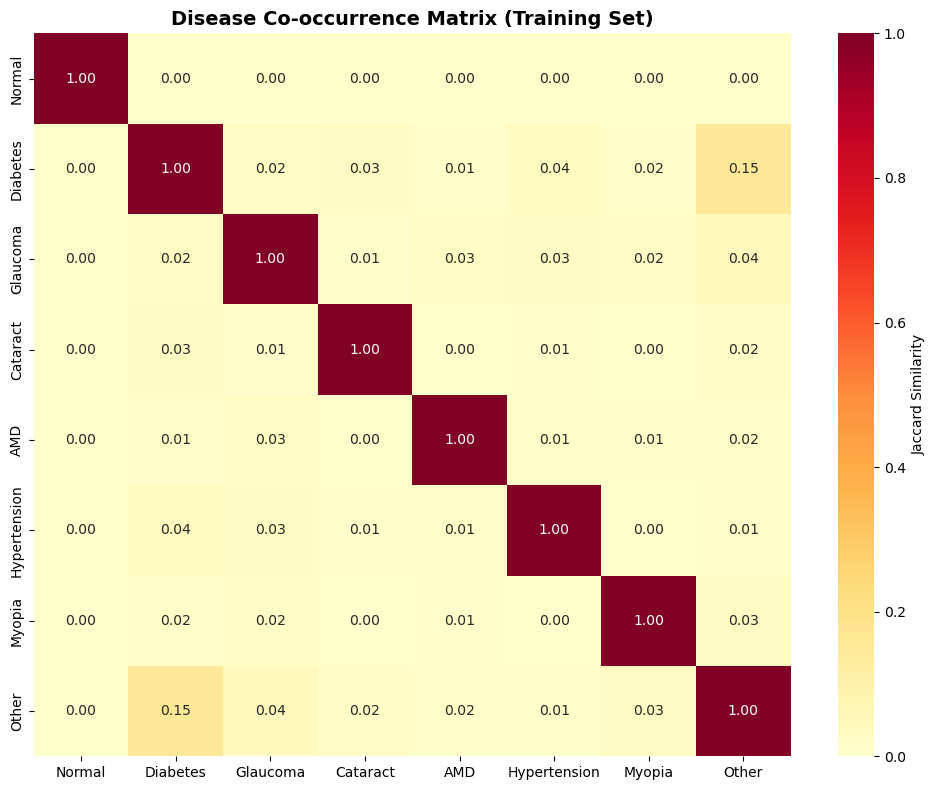


🔍 Most Common Disease Pairs:
  Diabetes + Other: 338 cases
  Diabetes + Hypertension: 59 cases
  Glaucoma + Other: 54 cases
  Diabetes + Cataract: 52 cases
  Diabetes + Glaucoma: 42 cases
  Myopia + Other: 36 cases
  Cataract + Other: 31 cases
  Diabetes + Myopia: 25 cases
  AMD + Other: 20 cases
  Diabetes + AMD: 19 cases

 Multi-label Statistics:
  Images with 0 diseases: 0 (0.0%)
  Images with 1 disease: 3791 (84.7%)
  Images with 2+ diseases: 683 (15.3%)
  Max diseases per image: 3
  Mean diseases per image: 1.16

📈 Per-Disease Statistics:
  Normal         : 1513 ( 33.8%)
  Diabetes       : 1470 ( 32.9%)
  Glaucoma       :  264 (  5.9%)
  Cataract       :  271 (  6.1%)
  AMD            :  223 (  5.0%)
  Hypertension   :  136 (  3.0%)
  Myopia         :  207 (  4.6%)
  Other          : 1100 ( 24.6%)
  📂 train: 4474 pacients, 5732 images

 Analyzing image quality (500 samples)...


100%|██████████| 500/500 [00:12<00:00, 41.49it/s]


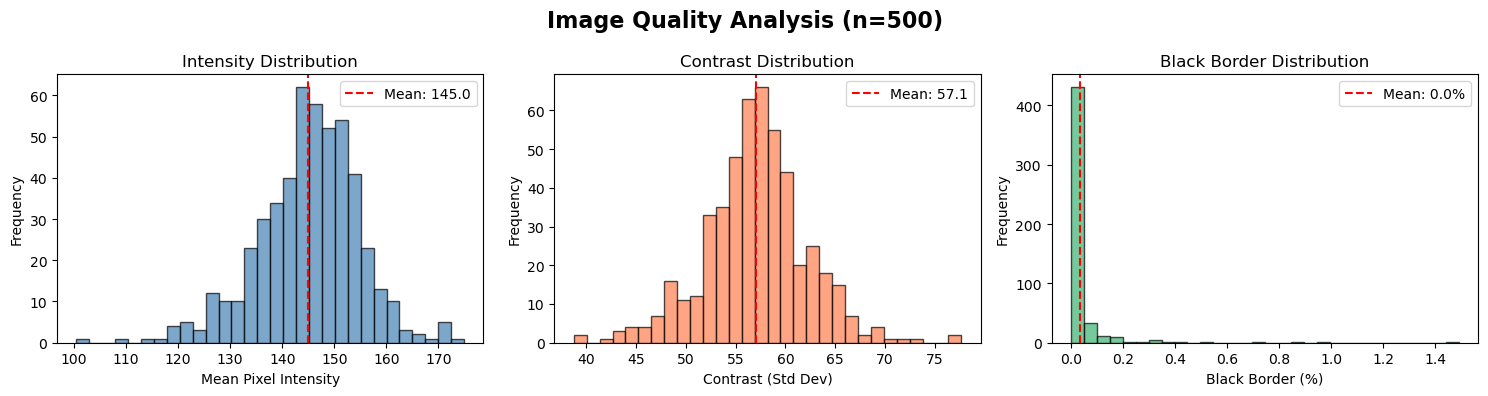


 Quality Metrics:
  Mean intensity: 145.0 ± 9.8
  Mean contrast: 57.1 ± 5.2
  Mean black border: 0.0% ± 0.1%
  Images with >10% black border: 0 (0.0%)

 Measuring Cropping Effect...


100%|██████████| 100/100 [00:01<00:00, 62.60it/s]


  Successfully analyzed: 100/100 images
  Mean pixels removed: 1.7% ± 1.5%
  Median: 1.8%
  Range: 0.0% - 11.7%
  Images with >20% removed: 0/100

 Measuring CLAHE Effect...
Loading datasets...
  📂 train: 4474 pacients, 5732 images
  📂 train: 4474 pacients, 5732 images
Analyzing 50 images...


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


Successfully analyzed: 50/50 images


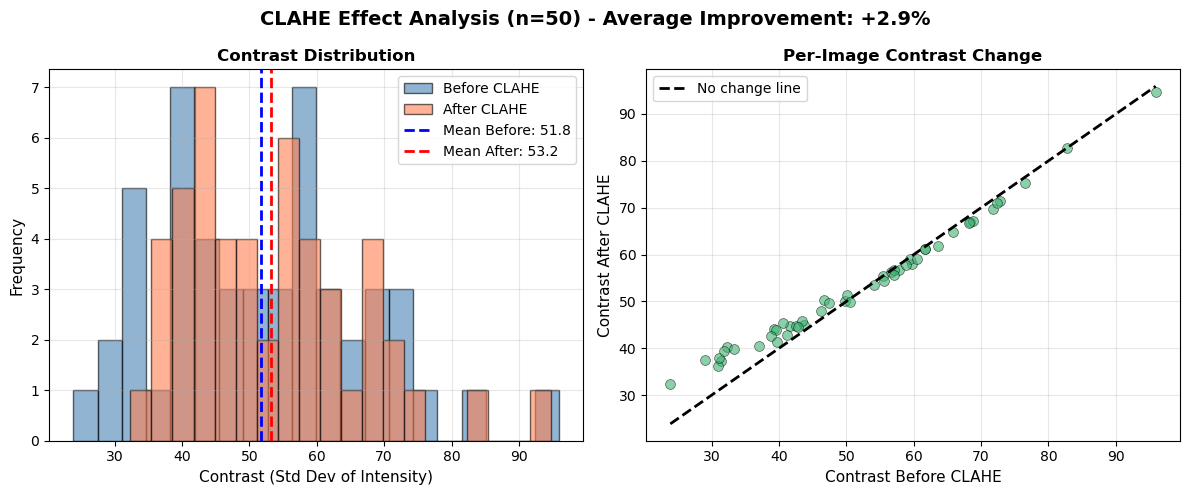


📊 Results:
  Mean contrast before: 51.76 ± 15.36
  Mean contrast after:  53.25 ± 12.82
  Average improvement:  +2.9%
  Min improvement:      +-37.5%
  Max improvement:      +83.1%

 Metrics saved to results/clahe_metrics.json
 Figure saved to results/clahe_effect.png
  📂 train: 4474 pacients, 5732 images

 Generating pipeline visualization (3 samples)...
  📂 train: 4474 pacients, 5732 images
  📂 train: 4474 pacients, 5732 images
 Pipeline visualization saved to results/pipeline_simple.png


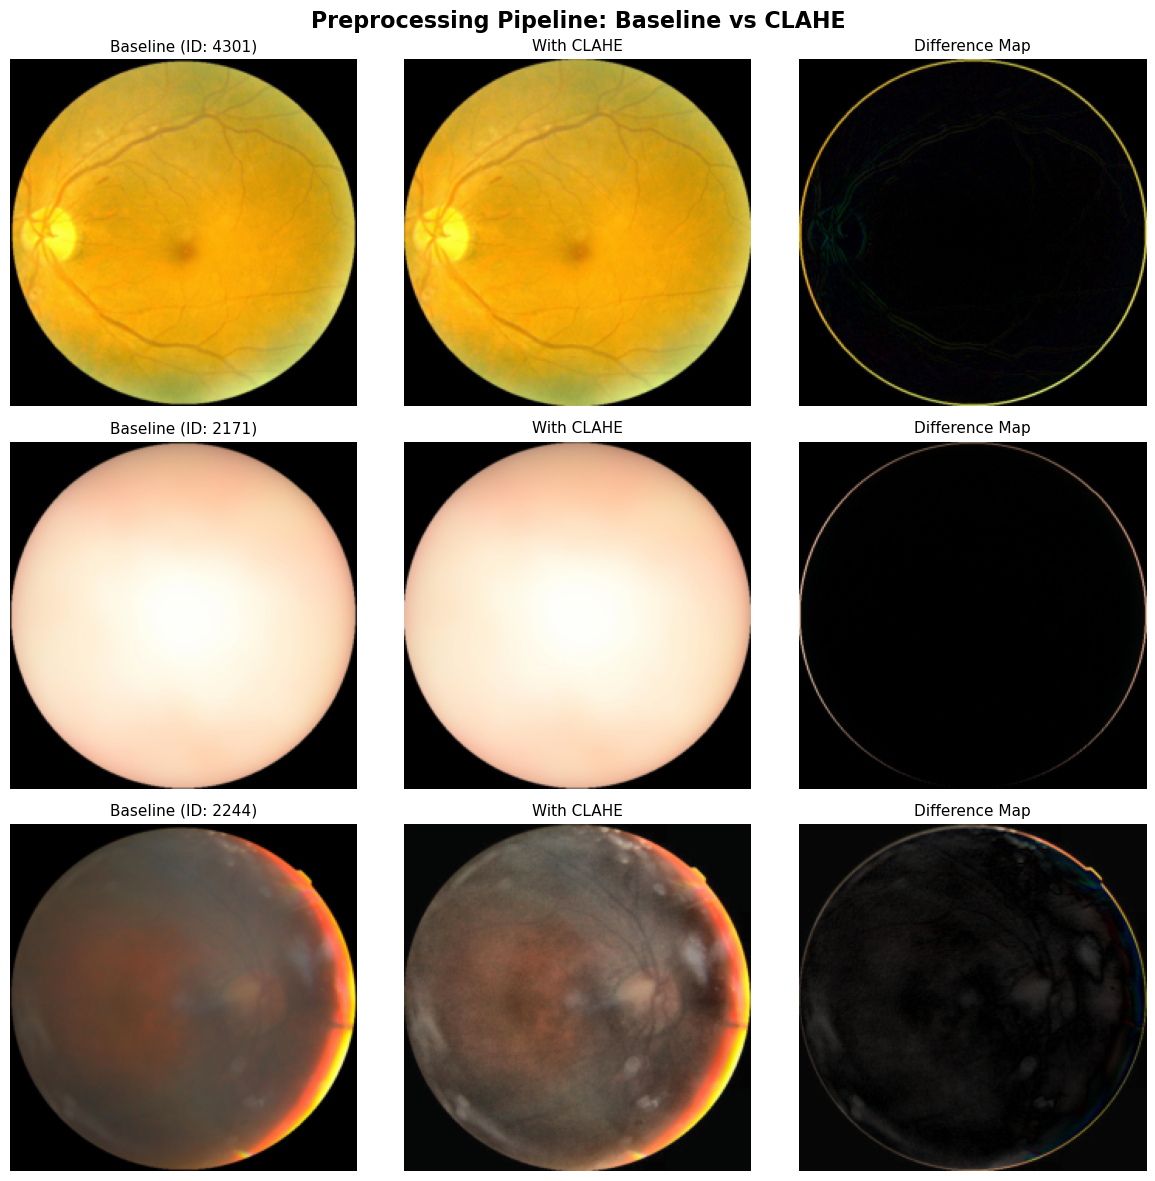


 All EDA and Preprocessing analyses completed!
   Check 'results/' folder for saved figures.


In [16]:
# ==================== ANÁLISES ADICIONAIS ====================

print("\n" + "="*60)
print("COMPREHENSIVE EDA & PREPROCESSING ANALYSIS")
print("="*60)

# 1. Dataset Summary Table
dataset_summary = print_dataset_summary()

# 2. Multi-label Co-occurrence
train_data = pd.read_csv(os.path.join(DATASET_ROOT, 'train', 'train_metadata.csv'))
plot_disease_cooccurrence(train_data)
analyze_multilabel_distribution(train_data)

# 3. Image Quality Analysis
train_dataset_basic = ODIRDataset('train', transform=get_val_test_transform())
analyze_image_quality(train_dataset_basic, num_samples=500)

# 4. Cropping Effect
measure_cropping_effect(train_dataset_basic, num_samples=100)

# 5. CLAHE Effect
measure_clahe_effect(num_samples=50)

# 6. Complete Pipeline Visualization
train_dataset_clahe = ODIRDataset('train', transform=get_train_transform_CLAHE())
visualize_complete_pipeline(num_samples=3)

print("\n All EDA and Preprocessing analyses completed!")
print("   Check 'results/' folder for saved figures.")

In [17]:
assert 'ODIRDataset' in dir(), "❌ ODIRDataset não encontrado!"
assert 'ApplyCLAHEandCrop_Adaptive' in dir(), "❌ ApplyCLAHEandCrop_Adaptive não encontrado!"

print("✅ ODIRDataset: OK")
print("✅ ApplyCLAHEandCrop_Adaptive: OK")
print("✅ CropOnly: OK" if 'CropOnly' in dir() else "⚠️ CropOnly não definido")

✅ ODIRDataset: OK
✅ ApplyCLAHEandCrop_Adaptive: OK
✅ CropOnly: OK


In [18]:
# ==================== TRANSFORMAÇÕES PARA TREINAR MODELOS ====================

def get_v1_baseline_transform():
    """V1: Baseline puro (SEM crop, SEM aug, SEM CLAHE)"""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v2_crop_only_transform():
    """V2: Só cropping (SEM aug, SEM CLAHE)"""
    return transforms.Compose([
        CropOnly(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v3_crop_aug_transform():
    """V3: Cropping + Augmentation (SEM CLAHE)"""
    return transforms.Compose([
        CropOnly(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])


def get_v4_full_pipeline_transform():
    """V4: Full Pipeline (Crop + Aug + CLAHE)"""
    return transforms.Compose([
        ApplyCLAHEandCrop_Adaptive(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

In [19]:
def create_datasets_for_config(config_name):
    """
    Criar train/val/test datasets para uma configuração
    
    Args:
        config_name: 'v1', 'v2', 'v3', ou 'v4'
    
    Returns:
        dict com keys 'train', 'val', 'test'
    """
    
    train_transforms = {
        'v1': get_v1_baseline_transform(),
        'v2': get_v2_crop_only_transform(),
        'v3': get_v3_crop_aug_transform(),
        'v4': get_v4_full_pipeline_transform()
    }
    
    val_test_transforms = {
        'v1': get_val_test_transform(),
        'v2': get_val_test_transform(),
        'v3': get_val_test_transform(),
        'v4': get_val_test_transform_CLAHE()
    }
    
    print(f"\n📦 Criando datasets para config: {config_name.upper()}")
    
    datasets = {
        'train': ODIRDataset('train', transform=train_transforms[config_name]),
        'val': ODIRDataset('val', transform=val_test_transforms[config_name]),
        'test': ODIRDataset('test', transform=val_test_transforms[config_name])
    }
    
    print(f"✅ Datasets {config_name} criados!")
    
    return datasets

In [20]:
# ==================== VERIFICAÇÃO FINAL ====================

print("\n" + "="*60)
print("VERIFICAÇÃO - Tudo pronto para usar noutros notebooks")
print("="*60)

checklist = {
    'ODIRDataset': 'ODIRDataset' in dir(),
    'ApplyCLAHEandCrop_Adaptive': 'ApplyCLAHEandCrop_Adaptive' in dir(),
    'CropOnly': 'CropOnly' in dir(),
    'get_v1_baseline_transform': 'get_v1_baseline_transform' in dir(),
    'get_v2_crop_only_transform': 'get_v2_crop_only_transform' in dir(),
    'get_v3_crop_aug_transform': 'get_v3_crop_aug_transform' in dir(),
    'get_v4_full_pipeline_transform': 'get_v4_full_pipeline_transform' in dir(),
    'get_val_test_transform': 'get_val_test_transform' in dir(),
    'get_val_test_transform_CLAHE': 'get_val_test_transform_CLAHE' in dir(),
    'create_datasets_for_config': 'create_datasets_for_config' in dir(),
}

all_ok = True
for item, exists in checklist.items():
    status = "✅" if exists else "❌"
    print(f"{status} {item}")
    if not exists:
        all_ok = False

if all_ok:
    print("\n🎉 TUDO PRONTO! Podes usar %run neste notebook.")
else:
    print("\n⚠️ Alguns itens em falta. Verifica o código acima.")


VERIFICAÇÃO - Tudo pronto para usar noutros notebooks
✅ ODIRDataset
✅ ApplyCLAHEandCrop_Adaptive
✅ CropOnly
✅ get_v1_baseline_transform
✅ get_v2_crop_only_transform
✅ get_v3_crop_aug_transform
✅ get_v4_full_pipeline_transform
✅ get_val_test_transform
✅ get_val_test_transform_CLAHE
✅ create_datasets_for_config

🎉 TUDO PRONTO! Podes usar %run neste notebook.


In [21]:
def find_optimal_threshold(dataset, thresholds=[30, 35, 40, 45, 50,  55, 60, 65, 70], n_samples=100):
    """
    Testar diferentes thresholds para ver qual melhora mais
    """
    
    results = {}
    
    for threshold in thresholds:
        print(f"\n{'='*70}")
        print(f"Testing threshold={threshold}")
        print(f"{'='*70}")
        
        contrast_before = []
        contrast_after = []
        n_applied = 0  # Quantas imagens aplicaram CLAHE
        
        for i in range(min(n_samples, len(dataset))):
            # Original
            img, _, _ = dataset[i]
            img_np = np.array(img)
            
            # Crop
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            mask = gray > 10
            if np.any(mask):
                coords = np.argwhere(mask)
                y0, x0 = coords.min(axis=0)
                y1, x1 = coords.max(axis=0) + 1
                img_cropped = img_np[y0:y1, x0:x1]
            else:
                img_cropped = img_np
            
            # Medir contraste ANTES
            gray_before = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)
            contrast_orig = gray_before.std()
            contrast_before.append(contrast_orig)
            
            # Aplicar CLAHE adaptativo
            if contrast_orig < threshold:
                n_applied += 1
                
                lab = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
                l = clahe.apply(l)
                img_final = cv2.merge([l, a, b])
                img_final = cv2.cvtColor(img_final, cv2.COLOR_LAB2RGB)
            else:
                img_final = img_cropped
            
            # Medir contraste DEPOIS
            gray_after = cv2.cvtColor(img_final, cv2.COLOR_RGB2GRAY)
            contrast_after.append(gray_after.std())
        
        # Stats
        before_mean = np.mean(contrast_before)
        after_mean = np.mean(contrast_after)
        improvement = (after_mean - before_mean) / before_mean * 100
        pct_applied = n_applied / n_samples * 100
        
        print(f"Contrast BEFORE: {before_mean:.2f}")
        print(f"Contrast AFTER:  {after_mean:.2f}")
        print(f"Improvement:     {improvement:+.2f}%")
        print(f"CLAHE applied:   {n_applied}/{n_samples} ({pct_applied:.1f}%)")
        
        results[threshold] = {
            'improvement': improvement,
            'pct_applied': pct_applied,
            'before_mean': before_mean,
            'after_mean': after_mean
        }
    
    # Encontrar melhor
    print(f"\n{'='*70}")
    print("SUMMARY")
    print(f"{'='*70}")
    
    best_threshold = max(results.keys(), key=lambda k: results[k]['improvement'])
    
    for threshold, data in sorted(results.items()):
        marker = "⭐ BEST" if threshold == best_threshold else ""
        print(f"Threshold {threshold}: {data['improvement']:+.2f}% "
              f"({data['pct_applied']:.0f}% images) {marker}")
    
    print(f"\n✅ OPTIMAL: threshold={best_threshold}")
    print(f"   Improvement: {results[best_threshold]['improvement']:+.2f}%")
    print(f"   Applied to: {results[best_threshold]['pct_applied']:.0f}% of images")
    
    return best_threshold, results

#dataset = ODIRDataset('train', transform=None)
#optimal_threshold, results = find_optimal_threshold(dataset, n_samples=500)

In [22]:
# ==================== VALIDAR clipLimit ÓTIMO ====================

def find_optimal_cliplimit(dataset, threshold=50, clip_limits=[0.5, 1.0, 1.5, 2.0, 2.5], n_samples=500):
    """
    Testar diferentes clipLimits com threshold fixo
    
    Args:
        threshold: Threshold otimizado (fixo em 50)
        clip_limits: Valores de clipLimit para testar
        n_samples: Número de amostras
    """
    
    results = {}
    
    print(f"\n{'='*70}")
    print(f"TESTING clipLimit (threshold={threshold} FIXED)")
    print(f"{'='*70}")
    
    for clip_limit in clip_limits:
        print(f"\n{'='*70}")
        print(f"Testing clipLimit={clip_limit}")
        print(f"{'='*70}")
        
        contrast_before = []
        contrast_after = []
        n_applied = 0
        
        for i in range(min(n_samples, len(dataset))):
            # Original
            img, _, _ = dataset[i]
            img_np = np.array(img)
            
            # Crop
            gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            mask = gray > 10
            if np.any(mask):
                coords = np.argwhere(mask)
                y0, x0 = coords.min(axis=0)
                y1, x1 = coords.max(axis=0) + 1
                img_cropped = img_np[y0:y1, x0:x1]
            else:
                img_cropped = img_np
            
            # Medir contraste ANTES
            gray_before = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)
            contrast_orig = gray_before.std()
            contrast_before.append(contrast_orig)
            
            # Aplicar CLAHE adaptativo com clipLimit variável
            if contrast_orig < threshold:
                n_applied += 1
                
                lab = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                
                # CLAHE com clipLimit testado
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
                l = clahe.apply(l)
                
                img_final = cv2.merge([l, a, b])
                img_final = cv2.cvtColor(img_final, cv2.COLOR_LAB2RGB)
            else:
                img_final = img_cropped
            
            # Medir contraste DEPOIS
            gray_after = cv2.cvtColor(img_final, cv2.COLOR_RGB2GRAY)
            contrast_after.append(gray_after.std())
        
        # Stats
        before_mean = np.mean(contrast_before)
        before_std = np.std(contrast_before)
        after_mean = np.mean(contrast_after)
        after_std = np.std(contrast_after)
        
        improvement = (after_mean - before_mean) / before_mean * 100
        std_reduction = (before_std - after_std) / before_std * 100
        pct_applied = n_applied / n_samples * 100
        
        print(f"Contrast BEFORE: {before_mean:.2f} ± {before_std:.2f}")
        print(f"Contrast AFTER:  {after_mean:.2f} ± {after_std:.2f}")
        print(f"Improvement:     {improvement:+.2f}%")
        print(f"STD reduction:   {std_reduction:.1f}%")
        print(f"CLAHE applied:   {n_applied}/{n_samples} ({pct_applied:.1f}%)")
        
        results[clip_limit] = {
            'improvement': improvement,
            'std_reduction': std_reduction,
            'pct_applied': pct_applied,
            'before_mean': before_mean,
            'after_mean': after_mean,
            'before_std': before_std,
            'after_std': after_std
        }
    
    # Encontrar melhor
    print(f"\n{'='*70}")
    print("SUMMARY")
    print(f"{'='*70}")
    
    best_clip = max(results.keys(), key=lambda k: results[k]['improvement'])
    
    print(f"\nclipLimit comparison (threshold={threshold}, applied to {results[list(results.keys())[0]]['pct_applied']:.0f}% images):")
    print(f"{'clipLimit':<12} {'Improvement':<15} {'STD reduction':<15} {'Best?'}")
    print("-" * 70)
    
    for clip_limit, data in sorted(results.items()):
        marker = "⭐ BEST" if clip_limit == best_clip else ""
        std_marker = "⚠️ High" if data['std_reduction'] > 20 else ""
        
        print(f"{clip_limit:<12} {data['improvement']:+.2f}%{'':<11} "
              f"{data['std_reduction']:.1f}%{'':<11} {marker} {std_marker}")
    
    print(f"\n✅ OPTIMAL: clipLimit={best_clip}")
    print(f"   Improvement: {results[best_clip]['improvement']:+.2f}%")
    print(f"   STD reduction: {results[best_clip]['std_reduction']:.1f}%")
    
    # Warnings
    if results[best_clip]['std_reduction'] > 25:
        print(f"\n⚠️  WARNING: STD reduction > 25%")
        print(f"   clipLimit={best_clip} pode estar removendo variabilidade demais")
        print(f"   Considerar clipLimit mais baixo")
    
    return best_clip, results


# ==================== EXECUTAR ====================

#dataset = ODIRDataset('train', transform=None)

# Testar clipLimits comuns
#clip_limits = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

#optimal_clip, results = find_optimal_cliplimit(
#    dataset,
#    threshold=50,      # ← Threshold já otimizado
#    clip_limits=clip_limits,
#    n_samples=2500
#)
